In [143]:
import os
import sys
from importlib import reload
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
        
from time import time 
import csv

import numpy as np
import scipy as sc
import pandas as pd
from sklearn.model_selection import train_test_split

import rna
import models
import utils
import vae

import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams["font.size"] = 12

import seaborn as sns
sns.set_style('darkgrid')

In [138]:
# generate training data
reload(rna)
n_train = 5000
p_mut = 0.1
noise_sd = 0.02

rnabind = rna.RNABinding()
trainseq_n, ytrain_n = rnabind.get_training_data(
    n_train,
    p_mut,
    noise_sd=noise_sd
)
testseq_n, ytest_n = rnabind.get_training_data(
    n_train,
    p_mut,
    noise_sd=noise_sd
)

Generating 5000 labeled sequences...
Done. (55 s)
Generating 5000 labeled sequences...
Done. (55 s)


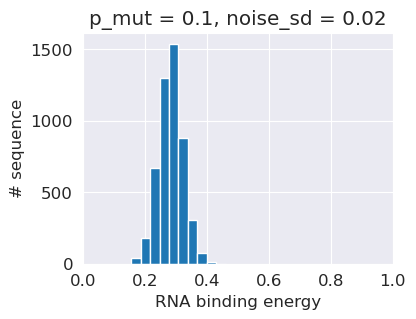

In [139]:
plt.figure(figsize=(4, 3))
plt.hist(ytrain_n)
plt.xlabel('RNA binding energy');
plt.ylabel('# sequence');
plt.title('p_mut = {}, noise_sd = {}'.format(p_mut, noise_sd));
plt.xlim([0, 1]);

CV-selected alpha: 10.0


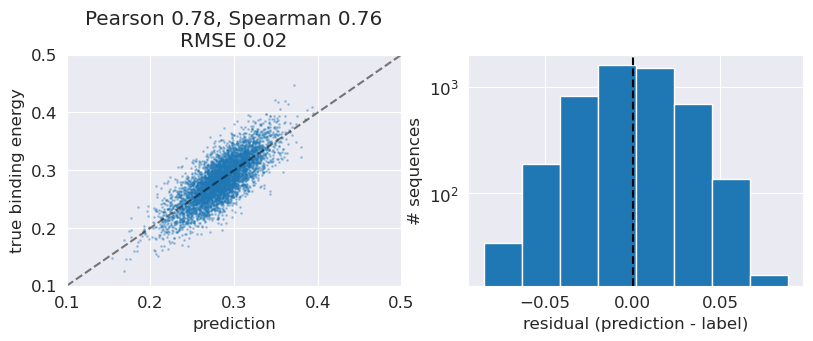

In [197]:
reload(models)
model = models.RidgeRegressor(seq_len=50, alphabet=rna.RNA_NUCLEOTIDES)
model.fit(trainseq_n, ytrain_n)
print(f'CV-selected alpha: {model.model.alpha_}')
predtest_n = model.predict(testseq_n)

xy_lim = [0.1, 0.5]
plt.figure(figsize=(9.5, 3))
plt.subplot(121)
plt.scatter(predtest_n, ytest_n, alpha=0.3, s=1);
plt.plot(xy_lim, xy_lim, '--k', alpha=0.5)
r, p = sc.stats.pearsonr(ytest_n, predtest_n)
rho, p = sc.stats.spearmanr(ytest_n, predtest_n)
rmse = np.sqrt(np.mean(np.square(ytest_n - predtest_n)))

plt.ylim(xy_lim);
plt.xlim(xy_lim)
plt.title('Pearson {:.2f}, Spearman {:.2f}\nRMSE {:.2f}'.format(r, rho, rmse));
plt.ylabel('true binding energy'); plt.xlabel('prediction');

plt.subplot(122)
plt.hist(predtest_n - ytest_n, bins=8, log=True);
plt.ylabel('# sequences')
plt.axvline(0, linestyle='--', color='k')
plt.xlabel('residual (prediction - label)');

No fitness variance estimates provided. Using unweighted MSE loss.
One-hot encoded sequences to shape = (5000, 50, 4) (0 sec)
4500 training data points, 500 validation data points.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 108.63it/s]


Epoch 0. Train loss: 0.01. Val loss: 0.10. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 114.15it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 121.04it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 107.51it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 0 sec.


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:00<00:00, 123.20it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 0 sec.


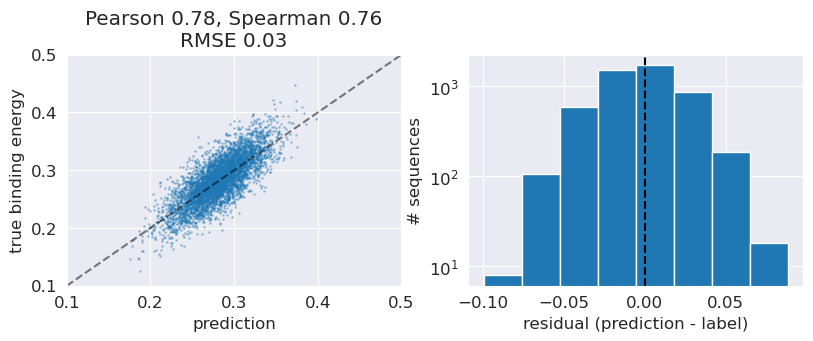

In [141]:
reload(models)
reload(rna)
n_hidden = 100
n_epoch = 5
lr = 0.001
model = models.FeedForward(50, rna.RNA_NUCLEOTIDES, n_hidden)
loss_tx2 = model.fit(
    trainseq_n,
    ytrain_n,
    n_epoch=n_epoch,
    lr=lr,
)

predtest_n = model.predict(testseq_n)

xy_lim = [0.1, 0.5]
plt.figure(figsize=(9.5, 3))
plt.subplot(121)
plt.scatter(predtest_n, ytest_n, alpha=0.3, s=1);
plt.plot(xy_lim, xy_lim, '--k', alpha=0.5)
r, p = sc.stats.pearsonr(ytest_n, predtest_n)
rho, p = sc.stats.spearmanr(ytest_n, predtest_n)
rmse = np.sqrt(np.mean(np.square(ytest_n - predtest_n)))

plt.ylim(xy_lim);
plt.xlim(xy_lim)
plt.title('Pearson {:.2f}, Spearman {:.2f}\nRMSE {:.2f}'.format(r, rho, rmse));
plt.ylabel('true binding energy'); plt.xlabel('prediction');

plt.subplot(122)
plt.hist(predtest_n - ytest_n, bins=8, log=True);
plt.ylabel('# sequences')
plt.axvline(0, linestyle='--', color='k')
plt.xlabel('residual (prediction - label)');

No fitness variance estimates provided. Using unweighted MSE loss.
One-hot encoded sequences to shape = (5000, 50, 4) (0 sec)
4500 training data points, 500 validation data points.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 57.87it/s]


Epoch 0. Train loss: 0.00. Val loss: 0.05. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 57.21it/s]


Epoch 1. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 59.82it/s]


Epoch 2. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 54.68it/s]


Epoch 3. Train loss: 0.00. Val loss: 0.00. 1 sec.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:01<00:00, 55.51it/s]


Epoch 4. Train loss: 0.00. Val loss: 0.00. 1 sec.


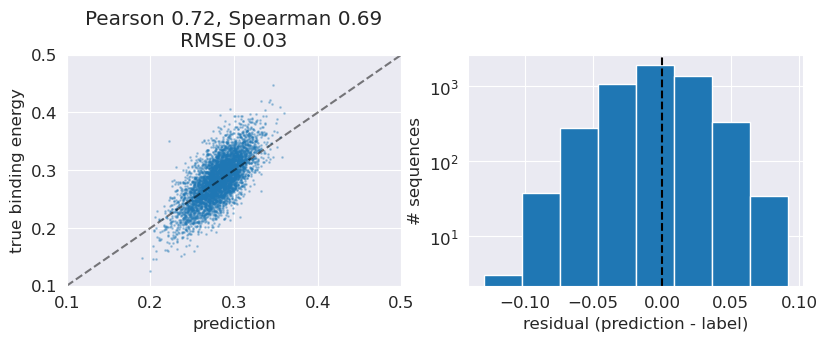

In [142]:
reload(models)
reload(rna)
n_filters = 32
n_hidden = 10
n_epoch = 5
lr = 0.001

model = models.CNN(50, rna.RNA_NUCLEOTIDES, n_filters, n_hidden)
loss_tx2 = model.fit(
    trainseq_n,
    ytrain_n,
    n_epoch=n_epoch,
    lr=lr,
)

predtest_n = model.predict(testseq_n)

xy_lim = [0.1, 0.5]
plt.figure(figsize=(9.5, 3))
plt.subplot(121)
plt.scatter(predtest_n, ytest_n, alpha=0.3, s=1);
plt.plot(xy_lim, xy_lim, '--k', alpha=0.5)
r, p = sc.stats.pearsonr(ytest_n, predtest_n)
rho, p = sc.stats.spearmanr(ytest_n, predtest_n)
rmse = np.sqrt(np.mean(np.square(ytest_n - predtest_n)))

plt.ylim(xy_lim);
plt.xlim(xy_lim)
plt.title('Pearson {:.2f}, Spearman {:.2f}\nRMSE {:.2f}'.format(r, rho, rmse));
plt.ylabel('true binding energy'); plt.xlabel('prediction');

plt.subplot(122)
plt.hist(predtest_n - ytest_n, bins=8, log=True);
plt.ylabel('# sequences')
plt.axvline(0, linestyle='--', color='k')
plt.xlabel('residual (prediction - label)');

# VAE

In [188]:
# generate training data
reload(rna)
n_train = 10000
p_mut = 0.1
noise_sd = 0.02

rnabind = rna.RNABinding()
trainseq_n, ytrain_n = rnabind.get_training_data(
    n_train,
    p_mut,
    noise_sd=noise_sd
)
predtrain_n = model.predict(trainseq_n)

Generating 10000 labeled sequences...
Done. (110 s)


One-hot encoded sequences to shape = (10000, 50, 4) (0 sec)
9000 training data points, 1000 validation data points.
Epoch 0. Train loss: 38.8046, KL: 1.4174, CE: 37.3871. Val loss: 50.5612, KL: 0.0927, CE: 50.4685. (4 s)
Epoch 1. Train loss: 27.2079, KL: 0.1930, CE: 27.0149. Val loss: 21.9387, KL: 0.2615, CE: 21.6772. (4 s)
Epoch 2. Train loss: 26.4693, KL: 0.0467, CE: 26.4227. Val loss: 20.9355, KL: 0.0414, CE: 20.8941. (4 s)
Epoch 3. Train loss: 26.2258, KL: 0.0303, CE: 26.1955. Val loss: 21.5191, KL: 0.0210, CE: 21.4980. (4 s)
Epoch 4. Train loss: 26.2559, KL: 0.0288, CE: 26.2271. Val loss: 22.2393, KL: 0.0158, CE: 22.2235. (4 s)
Epoch 5. Train loss: 26.2686, KL: 0.0225, CE: 26.2460. Val loss: 21.5232, KL: 0.0132, CE: 21.5101. (4 s)
Epoch 6. Train loss: 25.9260, KL: 0.0200, CE: 25.9060. Val loss: 21.2425, KL: 0.0140, CE: 21.2284. (4 s)
Epoch 7. Train loss: 25.9936, KL: 0.0116, CE: 25.9821. Val loss: 21.4337, KL: 0.0119, CE: 21.4218. (4 s)
Epoch 8. Train loss: 26.0141, KL: 0.0122, CE

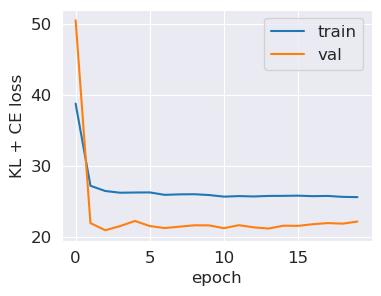

In [212]:
reload(vae)
latent_dim = 10
n_hidden = 20
lr = 0.001
n_epoch = 10

vae_model = vae.VAE(
    latent_dim=latent_dim,
    n_enc_hidden=n_hidden,
    n_dec_hidden=n_hidden
)

loss_df = vae_model.fit(
    trainseq_n,
    weight_n=np.fmax(predtrain_n - 0.35, 0),
    lr=lr,
    n_epoch=n_epoch
)

plt.figure(figsize=(4, 3))
plt.plot(loss_df.index, loss_df['train_loss'], label='train')
plt.plot(loss_df.index, loss_df['val_loss'], label='val')
plt.xlabel('epoch');
plt.ylabel('KL + CE loss');
plt.legend();

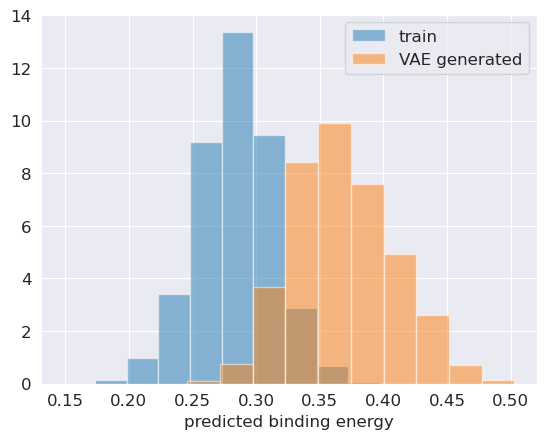

In [213]:
n_sample = 1000

genseq_n = vae_model.generate(n_sample)
ygen_n = rnabind.get_fitness(genseq_n)
predgen_n = model.predict(genseq_n)

plt.figure(figsize=(4, 3))
plt.hist(predtrain_n, alpha=0.5, density=True, label='train')
plt.hist(predgen_n, alpha=0.5, density=True, label='VAE generated')
plt.legend();
plt.xlabel('predicted binding energy');